In [1]:
import cv2
import matplotlib.pyplot as plt
import ndjson
import numpy as np
import os
import random
import skimage.transform

DIR_NAME = '/Users/phil/Documents/Soph/Spring/CS231N/PicIt/dataset'

In [2]:
!mkdir ../dataset

mkdir: ../dataset: File exists


In [3]:
def save_training_example(drawing, path, list_ids=None):
    """
    Saves a single training example to the directory of specified path. The filename will be set to the key_id.
    If list_ids is not None, the filename will be added to list_ids.
    @param drawing - dict: raw data from the Quick! Draw dataset with keys 'word', 'key_id', and 'drawing'
    @param path - str: folder where training examples will be stored
    @param list_ids - list: list of all the filenames of the training examples
    """
    filename = os.path.join(path, drawing['key_id'] + '.ndjson')
    if list_ids != None:
        list_ids.append(filename)
    if os.path.exists(filename):
        return

    drawing_simplified = [{'word': drawing['word'], 'key_id': drawing['key_id'], 'drawing': drawing['drawing']}]
    with open(filename, mode='w') as f:
        writer = ndjson.dump(drawing_simplified, f)

def parse_dataset(path=DIR_NAME):
    """
    Restructures dataset from '.ndjson' files into folders. Each folder will be of the form 'dataset/{LABEL}'
    and will contain 1 file per training example. Also saves the list of all filenames to 'filenames.txt'
    @param path - str: path to directory containing dataset
    @returns list containing all the filenames of the training examples (relative to path)
    @returns list containing all the labels of the dataset
    """
    directory = os.fsencode(path)
    list_ids = []
    labels = set()
    
    # If the filenames.txt file already exists, parse the file to find
    # list_ids and labels, and return early
    list_ids_filename = os.path.join(path, 'filenames.txt')
    if os.path.exists(list_ids_filename):
        with open(list_ids_filename) as f:
            list_ids = ndjson.load(f)
        for list_id in list_ids:
            label = os.path.basename(os.path.dirname(list_id))
            labels.add(label)
        return list_ids, labels

    # Loop through all '.ndjson' files and split into individual files
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        label, ext = os.path.splitext(filename)
        labels.add(label)
        if ext != '.ndjson':
            continue

        full_filename = os.path.join(path, filename)
        with open(full_filename) as f:
            dir_name = os.path.join(path, label)
            if not os.path.exists(dir_name):
                os.makedirs(dir_name)
            drawings = ndjson.load(f)
            for drawing in drawings:
                save_training_example(drawing, dir_name, list_ids)

    with open(list_ids_filename, 'w') as f:
        ndjson.dump(list_ids, f)
    return list_ids, list(labels)

In [4]:
list_ids, labels = parse_dataset()
print('Sample list id: ', list_ids[0])
print('Num labels: ', len(labels))

Sample list id:  /Users/phil/Documents/Soph/Spring/CS231N/PicIt/dataset/The Great Wall of China/4626156441567232.ndjson
Num labels:  8


In [5]:
def decode_drawing(raw_strokes, line_thickness=5, time_color=True, part_color=True, num_channels=3, size=128):
    """
    Decodes a drawing from its raw strokes into a numpy array
    @param raw_strokes - list: list containing x, y, and time of each raw stroke
    @param line_thickness - int: thickness to encode each raw stroke
    @param time_color - bool: whether or not to encode time as color
    @param part_color - bool: whether or not to further encode time as RBG division
    @param num_channels - int: number of color channels
    @param size - int: number of pixels to resize to

    @returns np.array (256 x 256 x num_channels) - decoded drawing as numpy array
    """
    img = np.zeros((256, 256, num_channels), dtype=np.uint8)
    for t, stroke in enumerate(raw_strokes):
        part_num = int(float(t) / len(raw_strokes) * num_channels)
        for i in range(len(stroke[0]) - 1):
            color = 255 - min(t, 20) * 10 if time_color else 255
            if part_color:
                if part_num == 1:
                    color = (0, color, color)
                elif part_num == 2:
                    color = (0, 0, color)
                else: # if part_num == 0:
                    color = (color, color, color)
            cv2.line(img, (stroke[0][i], stroke[1][i]), (stroke[0][i+1], stroke[1][i+1]),
                     color, line_thickness, cv2.LINE_AA)
    return skimage.transform.resize(img, (size, size), preserve_range=True)

In [6]:
from torch.utils import data

class Dataset(data.Dataset):
    """
    A dataset encapsulating numpy arrays from the QuickDraw dataset and images generated by composing
    the numpy dataset with itself to create new "multi-object" images
    """
    def __init__(self, list_IDs, labels, img_size=128):
        """
        @param list_IDs - list (str): list containing filenames of all training examples
        @param labels - list(str): list containing string names of all labels
        @param img_size - int: the size to convert images in the dataset
        """
        self.list_IDs = list_IDs
        self.labels = labels
        self.img_size = img_size
        self.labels_to_indices = {}
        
        for i, label in enumerate(self.labels):
            self.labels_to_indices[label] = i
    
    def __len__(self):
        return len(self.list_IDs)
    
    def __getitem__(self, index):
        """
        @returns drawing_decoded - np.array (img_size x img_size x 3): drawing decoded as 
                                    a np array
        @returns index - index of the correct label associated with the drawing
        """
        filename = self.list_IDs[index]
        with open(filename) as f:
            drawing = ndjson.load(f)
        drawing_decoded = decode_drawing(drawing[0]['drawing'], size=self.img_size)
        label = self.labels_to_indices[drawing[0]['word']]
        return drawing_decoded, label

    def generate_image(self, boxes, indices):
        """
        Generates a composition image given the bounding boxes and labels of the individual
        components
        @param boxes - ndarray (N x 4): the predicted boxes in [x1, y1, x2, y2]
        @param indices - np.array (N): the indices of the labels to add

        @returns np.array (img_size x img_size x 3): composite image
        @returns list (int): labels
        """
        assert len(boxes) == len(indices)
        image = np.zeros((self.img_size, self.img_size, 3))
        labels = []
        for i in range(len(boxes)):
            x1, y1, x2, y2 = boxes[i]
            new_shape = (x2 - x1, y2 - y1)

            obj, label = self.__getitem__(indices[i])
            obj_resized = skimage.transform.resize(obj, new_shape, preserve_range=True)
            image[x1:x2, y1:y2, :] = np.maximum(image[x1:x2, y1:y2, :], obj_resized)
            labels.append(label)
        return image, labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


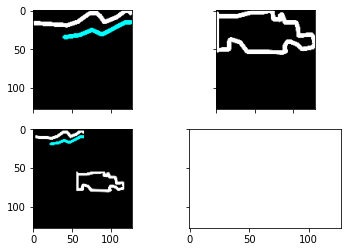

In [7]:
dataset = Dataset(list_ids, labels)
individual_imgs = [1, 1058352]
img1, label1 = dataset[individual_imgs[0]]
img2, label2 = dataset[individual_imgs[1]]
composite_img, composite_labels = dataset.generate_image([[2, 3, 65, 66], [55, 56, 113, 118]], individual_imgs)

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
axes[0,0].imshow(img1)
axes[0,1].imshow(img2)
axes[1,0].imshow(composite_img)